<a href="https://colab.research.google.com/github/MatteoFasulo/Sexism-detection/blob/main/assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sexism Detector - Assignment 1

## Group:
- Luca Babboni - luca.babboni2@studio.unibo.it  
- Matteo Fasulo - matteo.fasulo@studio.unibo.it  
- Maksim Omelchenko - maksim.omelchenko@studio.unibo.it  
- Luca Tedeschini - luca.tedeschini3@studio.unibo.it  

## Description:
This notebook addresses Task 1 proposed in [EXIST 2023](https://clef2023.clef-initiative.eu/index.php?page=Pages/labs.html#EXIST) on sexism detection. The following work follows, step by step, the tasks specified in the provided notebook.


# Libraries

Uncomment the following cell to install the required libraries in Google Colab.

In [1]:
#%%capture
#%pip install requests nltk gensim datasets evaluate transformers

In [2]:
import requests
import gc
import os
from pathlib import Path
import re
import json
from typing import OrderedDict
import copy

import unicodedata

import numpy as np
import pandas as pd

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay

from tqdm import tqdm
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer

import gensim
import gensim.downloader as gloader

import torch

from datasets import Dataset
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
import evaluate

# Class Definition

We decided to organize all the code within classes to keep the outputs well-organized and clean. Each method is documented with its respective docstring, and a high-level explanation of what we are doing will be written in markdown whenever we call the methods.


In [3]:
class SexismDetector:
    def __init__(self):
        URL_PATTERN_STR = r"""(?i)((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info
                      |int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|
                      bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|
                      cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|
                      gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|
                      la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|
                      nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|
                      sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|
                      uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]
                      *?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’])|(?:(?<!@)
                      [a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name
                      |post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn
                      |bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg
                      |eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id
                      |ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|
                      md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|
                      ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|
                      sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|
                      za|zm|zw)\b/?(?!@)))"""
        self.URL_PATTERN = re.compile(URL_PATTERN_STR, re.IGNORECASE)
        self.HASHTAG_PATTERN = re.compile(r'#\w*')
        self.MENTION_PATTERN = re.compile(r'@\w*')
        self.EMOJIS_PATTERN = re.compile(u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])')
        self.AND_PATTERN = re.compile(r'&amp;')
        self.PUNCT_REPEAT_PATTERN = re.compile(r'([!?.]){2,}')
        self.ELONG_PATTERN = re.compile(r'\b(\S*?)(.)\2{2,}\b')
        self.WORD_PATTERN = re.compile(r'[^\w<>\s]')
        self.SEED = 1337
        self.DATA_FOLDER = Path('data')
        self.MODEL_FOLDER = Path('models')
        self.columns_to_maintain = ['id_EXIST', 'lang', 'tweet', 'hard_label_task1']
        self.UNK_TOKEN = '[UNK]'
        self.PAD_TOKEN = '[PAD]'

    def download_corpus(self, url: str, filename: str) -> None:
        """
        Downloads a text corpus from a given URL and saves it to a specified filename within the data folder.

        Args:
            url (str): The URL from which to download the corpus.
            filename (str): The name of the file to save the downloaded corpus.

        Raises:
            requests.exceptions.HTTPError: If the HTTP request returned an unsuccessful status code.

        Side Effects:
            Creates the data folder if it does not exist.
            Writes the downloaded corpus to the specified file.
        """
        if not self.DATA_FOLDER.exists():
            self.DATA_FOLDER.mkdir(parents=True)
            print(f"Created folder {self.DATA_FOLDER}.")

        response = requests.get(url)
        response.raise_for_status()
        with open(self.DATA_FOLDER / filename, 'w', encoding='utf-8') as f:
            f.write(response.text)

    def load_corpus(self, filename: str, *args, **kwargs) -> pd.DataFrame:
        """
        Load a corpus from a JSON file.

        Parameters:
        filename (str): The name of the JSON file to load.
        *args: Variable length argument list to pass to pandas read_json.
        **kwargs: Arbitrary keyword arguments to pass to pandas read_json.

        Returns:
        DataFrame: A pandas DataFrame containing the loaded corpus.
        """
        return pd.read_json(self.DATA_FOLDER / filename, *args, **kwargs)

    @staticmethod
    def majority_voting(votes: list[str]) -> str:
        """
        Determines the majority vote from a list of votes.
        Args:
            votes (list[str]): A list of votes, where each vote is either "YES" or "NO".
        Returns:
            str: The result of the majority vote. Returns "YES" if there are more "YES" votes,
                "NO" if there are more "NO" votes, and "NEUTRAL" in case of a tie.
        """
        total_num_votes = len(votes)
        yes_votes = votes.count("YES")
        no_votes = total_num_votes - yes_votes

        if yes_votes > no_votes:
            return "YES"
        elif no_votes > yes_votes:
            return "NO"
        else:
            return "NEUTRAL" # This will be the case when there is a tie (removed later)

    def preprocess_text(self, text: str) -> str:
        """
        Preprocesses the input text by removing or replacing specific patterns.

        Args:
            text (str): The input text to be preprocessed.

        Returns:
            str: The preprocessed text with URLs, mentions, hashtags, emojis,
                 special characters removed, 'and' replaced, and extra spaces trimmed.
        """
        # Convert URL to <URL> so that GloVe will have a vector for it
        text = re.sub(self.URL_PATTERN, ' <URL>', text)
        # Add spaces around slashes
        text = re.sub(r"/", " / ", text)
        # Replace mentions with <USER>
        text = re.sub(self.MENTION_PATTERN, ' <USER> ', text)
        # Replace numbers with <NUMBER>
        text = re.sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", " <NUMBER> ", text)
        # Replace hashtags with <HASHTAG>
        text = re.sub(self.HASHTAG_PATTERN, ' <HASHTAG> ', text)
        #text = self.AND_PATTERN.sub('and', text) # &amp; already in the Vocab of GloVe-twitter
        # Replace multiple punctuation marks with <REPEAT>
        text = re.sub(self.PUNCT_REPEAT_PATTERN, lambda match: f" {match.group(1)} <REPEAT> ", text)
        # Replace elongated words with <ELONG>
        text = re.sub(self.ELONG_PATTERN, lambda match: f" {match.group(1)}{match.group(2)} <ELONG> ", text)
        #text = emoji.replace_emoji(text, replace='') # some emojis are in the vocab so we do not remove them, the others will be OOVs
        text = text.strip()
        # Get only words
        text = re.sub(self.WORD_PATTERN, ' ', text)
        text = text.strip()
        # Convert stylized Unicode characters to plain text (removes bold text, etc.)
        text = ''.join(c for c in unicodedata.normalize('NFKD', text) if not unicodedata.combining(c))
        return text

    def lemmatize_text(self, text: str) -> str:
        """
        Lemmatizes the input text using the WordNet lemmatizer.

        This method attempts to lemmatize each word in the input text. If the WordNet
        data is not available, it will download the necessary data and retry.

        Args:
            text (str): The input text to be lemmatized.

        Returns:
            str: The lemmatized text.
        """
        lemmatizer = WordNetLemmatizer()
        downloaded = False
        while not downloaded:
            try:
                lemmatizer.lemmatize(text)
                downloaded = True
            except LookupError:
                print("Downloading WordNet...")
                nltk.download('wordnet')
        return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    @staticmethod
    def text_diff(original_text: str, preprocessed_text: str, random: bool = True) -> None:
        """
        Displays a comparison between an original tweet and its preprocessed version.
        Args:
            original_text (str): The original text data containing tweets.
            preprocessed_text (str): The preprocessed text data containing tweets.
            random (bool, optional): If True, a random tweet is selected for comparison.
                                     If False, the first tweet is selected. Defaults to True.
        Returns:
            None
        """
        if random:
            idx = np.random.randint(0, preprocessed_text.shape[0])
        else:
            idx = 0

        print(f"Original tweet:\n{original_text['tweet'].iloc[idx]}")
        print(f"Processed tweet:\n{preprocessed_text['tweet'].iloc[idx]}")

    def load_glove(self, model_name: str = 'glove-wiki-gigaword', embedding_dim: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
        """
        Loads the GloVe model with the specified name and embedding dimension.
        Args:
            model_name (str): The name of the GloVe model to load. Default is 'glove-wiki-gigaword'.
            embedding_dim (int): The dimension of the word embeddings. Default is 50.
        Returns:
            gensim.models.keyedvectors.KeyedVectors: The loaded GloVe model.
        Raises:
            Exception: If there is an error in downloading or loading the model.
        Notes:
            - If the model folder does not exist, it will be created.
            - If the model is not already downloaded, it will be downloaded and saved to the specified path.
            - If the model is already downloaded, it will be loaded from the specified path.
        """
        self.EMBEDDING_DIM = embedding_dim

        if not self.MODEL_FOLDER.exists():
            self.MODEL_FOLDER.mkdir(parents=True)
            print(f"Created folder {self.MODEL_FOLDER}.")

        model_path = self.MODEL_FOLDER / f"{model_name}-{embedding_dim}"
        if not model_path.exists():
            print(f"Downloading {model_name} model...")
            glove_model = gloader.load(f"{model_name}-{embedding_dim}")
            print(f"Model downloaded! Saving to {model_path}")
            glove_model.save(str(model_path))
            print(f"Model saved to {self.MODEL_FOLDER / f'{model_name}-{embedding_dim}'}")
        else:
            glove_model = gensim.models.keyedvectors.KeyedVectors.load(str(model_path))
        return glove_model

    def get_vocab(self, data: pd.DataFrame) -> tuple[OrderedDict, OrderedDict]:
        """
        Generates vocabulary mappings from a given dataset.
        Args:
            data (pd.DataFrame): A pandas DataFrame containing the dataset with a column 'tweet'.
            word_listing (list, optional): A list of words to include in the vocabulary. If None, the vocabulary
                                           will be built from the dataset. Defaults to None.
        Returns:
            tuple[OrderedDict, OrderedDict]: A tuple containing two OrderedDicts:
                - idx_to_word: Mapping from index to word.
                - word_to_idx: Mapping from word to index.
        """
        idx_to_word = OrderedDict()
        word_to_idx = OrderedDict()

        curr_idx = 0
        for sentence in data.tweet.values:
            tokens = sentence.split()
            for token in tokens:
                if token not in word_to_idx:
                    word_to_idx[token] = curr_idx
                    idx_to_word[curr_idx] = token
                    curr_idx += 1

        word_listing = list(idx_to_word.values())
        return idx_to_word, word_to_idx, word_listing

    def co_occurrence_count(self, df: pd.DataFrame, idx_to_word, word_to_idx, window_size: int = 10) -> np.ndarray:

        vocab_size = len(idx_to_word)
        co_occurrence_matrix = np.zeros((vocab_size, vocab_size), dtype=np.float32)

        for sentence in tqdm(df.tweet.values):
            tokens = sentence.split()
            for pos, token in enumerate(tokens):
                start = max(0, pos - window_size)
                end = min(pos + window_size + 1, len(tokens))

                first_word_index = word_to_idx[token]

                for pos2 in range(start, end):
                    if pos2 != pos:
                        second_token = tokens[pos2]
                        second_word_index = word_to_idx[second_token]
                        co_occurrence_matrix[first_word_index, second_word_index] += 1

        return co_occurrence_matrix

    def co_occurrence_dataframe(self, co_occurrence_matrix: np.ndarray, idx_to_word: OrderedDict) -> pd.DataFrame:
        """
        Converts a co-occurrence matrix into a pandas DataFrame with word indices as row and column labels.
        Args:
            co_occurrence_matrix (np.ndarray): A co-occurrence matrix with word indices as row and column indices.
            idx_to_word (OrderedDict): A mapping from word index to word.
        Returns:
            pd.DataFrame: A pandas DataFrame with word indices as row and column labels.
        """
        return pd.DataFrame(co_occurrence_matrix, index=idx_to_word.values(), columns=idx_to_word.values())

    def get_augmented_vocab(self, emb_model: gensim.models.keyedvectors.KeyedVectors, train_words: list, co_occurrence_df: pd.DataFrame, save: bool = False) -> gensim.models.keyedvectors.KeyedVectors:
        """
        Augments the given embedding model with new tokens from the training words list. If a token is not found in the
        embedding model, a random vector is generated for it. Optionally saves the updated vocabulary to a JSON file.
        Args:
            emb_model (gensim.models.keyedvectors.KeyedVectors): The embedding model to augment.
            train_words (list): A list of words to add to the embedding model.
            co_occurrence_df (pd.DataFrame): A DataFrame containing co-occurrence data for the training words.
            save (bool, optional): If True, saves the updated vocabulary to a JSON file. Defaults to False.
        Returns:
            gensim.models.keyedvectors.KeyedVectors: The augmented embedding model.
        """
        new_tokens = []
        new_vectors = []

        for token in train_words:
            try:
                embedding_vec = emb_model.get_vector(token)
            except KeyError:
                try:
                    # Handle missing token in embedding model
                    top_5_most_frequent = co_occurrence_df.loc[token].sort_values(ascending=False).index.tolist()[:5]

                    # Filter words that are in the embedding model
                    valid_words = [word for word in top_5_most_frequent if word in emb_model.key_to_index]

                    if valid_words: # TODO: check that valid words as atleast 2 words otherwise mean won't be significant
                        # Calculate the average vector for valid words
                        embedding_vec = np.mean([emb_model.get_vector(word) for word in valid_words], axis=0)
                    else:
                        # Handle the case where no valid co-occurring words exist
                        raise ValueError(f"No valid co-occurring words found for token: {token}")

                except Exception as e:
                    print(f"Generating random vector for token '{token}': {e}")
                    embedding_vec = np.random.uniform(low=-0.05, high=0.05, size=self.EMBEDDING_DIM)

            new_tokens.append(token)
            new_vectors.append(embedding_vec)

        emb_model.add_vectors(new_tokens, new_vectors)
        # add the UNK token to the embedding model with the vector which is the average of all the vectors
        emb_model.add_vectors(["[UNK]", "[PAD]"], [np.mean(emb_model.vectors, axis=0), np.zeros(self.EMBEDDING_DIM)])

        if save:
            vocab_path = self.DATA_FOLDER / 'vocab.json'
            print(f"Saving vocab to {vocab_path}")
            with vocab_path.open('w', encoding='utf-8') as f:
                json.dump(emb_model.key_to_index, f, indent=4)
            print("Vocab saved!")

        return emb_model

    def get_oov(self, embedding_model: gensim.models.keyedvectors.KeyedVectors, word_listing: list) -> set:
        """
        Returns a list of out-of-vocabulary (OOV) words from a given list of words.
        Args:
            embedding_model (gensim.models.keyedvectors.KeyedVectors): The word embedding model containing known words.
            word_listing (list): A list of words to check against the embedding model.
        Returns:
            set: A set of out-of-vocabulary words.
        """
        return set(word_listing).difference(set(embedding_model.key_to_index.keys()))

    def get_oov_stats(self, embedding_model: gensim.models.keyedvectors.KeyedVectors, word_listing: list) -> None:
        """
        Calculate and print the number and percentage of out-of-vocabulary (OOV) words.
        Args:
            embedding_model (gensim.models.keyedvectors.KeyedVectors): The word embedding model containing known words.
            word_listing (list): A list of words to check against the embedding model.
        Returns:
            None
        """
        OOV_token = self.get_oov(embedding_model, word_listing)
        OOV_percentage = float(len(OOV_token)) * 100 / len(word_listing)

        print(f"Total OOV terms: {len(OOV_token)} ({OOV_percentage:.2f}%)")

    def get_class_weights(self, data: pd.DataFrame, label_column: str) -> np.ndarray:
        """
        Computes class weights for a given dataset.
        Args:
            data (pd.DataFrame, optional): A pandas DataFrame containing the dataset. Defaults to None.
        Returns:
            np.ndarray: An array of class weights.
        """
        class_weights = compute_class_weight('balanced', classes=np.unique(data[label_column]), y=data[label_column])
        self.class_weights = torch.tensor(class_weights, dtype=torch.float32)
        return self.class_weights

    def get_padded_sequences(self, data: pd.Series, embedding_model: gensim.models.keyedvectors.KeyedVectors) -> torch.Tensor:
        """
        Converts a pandas Series of text data into padded sequences of word indices using a given embedding model.

        Args:
            data (pd.Series): A pandas Series containing text data.
            embedding_model (gensim.models.keyedvectors.KeyedVectors): A pre-trained word embedding model.

        Returns:
            torch.Tensor: A tensor containing padded sequences of word indices.
        """
        tokenizer = nltk.tokenize.NLTKWordTokenizer()
        unk_index = embedding_model.get_index(self.UNK_TOKEN)

        sequences = [torch.tensor([embedding_model.get_index(word, default=unk_index) for word in tokenizer.tokenize(x)]) for x in data.values]

        return torch.nn.utils.rnn.pad_sequence(sequences, padding_value=embedding_model.get_index(self.PAD_TOKEN), batch_first=True)

    def get_dataloader(self, data: pd.DataFrame, embedding_model: gensim.models.keyedvectors.KeyedVectors, type: str, *args, **kwargs) -> torch.utils.data.DataLoader:
        """
        Creates a DataLoader for the given dataset.

        Args:
            data (pd.DataFrame): DataFrame containing the data. Must have 'tweet' and 'label' columns.
            embedding_model (gensim.models.keyedvectors.KeyedVectors): Pre-trained embedding model to convert tweets to vectors.
            type (str): Type of dataset. Must be one of 'train', 'val', or 'test'.
            *args: Variable length argument list for DataLoader.
            **kwargs: Arbitrary keyword arguments for DataLoader.

        Returns:
            torch.utils.data.DataLoader: DataLoader for the given dataset.

        Raises:
            ValueError: If the type is not one of 'train', 'val', or 'test'.
        """
        if type not in ['train', 'val', 'test']:
            raise ValueError("Invalid type. Must be one of 'train', 'val', or 'test'.")
        padded_sequences = self.get_padded_sequences(data.tweet, embedding_model)
        labels = torch.tensor(data.label.values)
        dataset = TextDataset(padded_sequences, labels)
        return torch.utils.data.DataLoader(dataset, *args, **kwargs)

class TextDataset(torch.utils.data.Dataset):
    """
    A custom dataset class for handling text sequences and their corresponding labels.

    Args:
        sequences (torch.Tensor): A tensor containing the text sequences.
        labels (torch.Tensor): A tensor containing the labels for each text sequence.

    Attributes:
        sequences (torch.Tensor): Stores the text sequences.
        labels (torch.Tensor): Stores the labels for each text sequence.

    Methods:
        __len__(): Returns the number of text sequences in the dataset.
        __getitem__(idx): Returns the text sequence and label at the specified index.
    """
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return self.sequences.shape[0]

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Task 1: Corpus

1. Download the data
2. Load the JSON files and encode them as a DataFrame
3. Generate hard labels for Task 1 with majority voting
4. Filter the DataFrame for only english tweets
5. Remove unwanted columns
6. Encode the hard labels column as integers

>**Bonus**: explore also Spanish tweets leveraging multi-language models and assessing the performance of the model on the two languages in comparison to the English-only model.

Fist of all, we need to instantiate the class which we will use to perform the task.

In [4]:
detector = SexismDetector()

Let's define the device to use for the computation of PyTorch

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Constants

The constants are defined in the following cell. We will use them to define the embedding dimension and batch size.

In [6]:
# GloVe Embeddings
EMBEDDING_DIM = 50

# LSTMs
BATCH_SIZE = 1024
HIDDEN_DIM = 128
EPOCHS = 100
LEARNING_RATE = 1e-4

# Transformers (roBERTa)
ROBERTA_BATCH_SIZE = 16
ROBERTA_EPOCHS = 6
ROBERTA_LEARNING_RATE = 5e-6

# Set the seeds for reproducibility
seeds = [1337, 42, 69]

# Instantiate the predictions dict to store the predictions for each seed and model (LSTMs and Transformers)
predictions_dict = {}

### Download the data

The data is downloaded from the repository of the course. The `download_corpus` method is used to download the data from the repository and save it in the `data` folder under the root directory of the project.

In [7]:
detector.download_corpus(url='https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%201/data/training.json', filename='training.json')
detector.download_corpus(url='https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%201/data/test.json', filename='test.json')
detector.download_corpus(url='https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%201/data/validation.json', filename='validation.json')

Created folder data.


### Load the JSON files and encode them as a DataFrame

Then we load the JSON files and encode them as a DataFrame. The `load_corpus` method is used to load the data from the JSON files and encode them as a DataFrame.

In [8]:
train = detector.load_corpus('training.json', orient='index', encoding='utf-8')
val = detector.load_corpus('validation.json', orient='index', encoding='utf-8')
test = detector.load_corpus('test.json', orient='index', encoding='utf-8')

Make a copy of the test set to be used at the end to perform more in depth analysis about why the model is failing to classify the tweets.

In [9]:
test_copy = test.copy()

### Data exploration

We can briefly explore the dataset we are working with

In [10]:
train.head()

,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
100001,100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES
100002,100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES
100003,100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES
100004,100004,es,@Lunariita7 Un retraso social bastante lamenta...,6,"[Annotator_13, Annotator_14, Annotator_15, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, YES, NO, YES, YES]","[-, -, DIRECT, -, REPORTED, REPORTED]","[[-], [-], [IDEOLOGICAL-INEQUALITY], [-], [IDE...",TRAIN_ES
100005,100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,6,"[Annotator_19, Annotator_20, Annotator_21, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, NO, YES, NO, YES, YES]","[REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION], [-...",TRAIN_ES


In [11]:
train.shape, val.shape, test.shape

((6920, 11), (726, 11), (312, 11))

### Generate hard labels for Task 1 with majority voting

The hard labels for Task 1 are generated with majority voting. The `majority_voting` method is used to generate the hard labels for Task 1 with majority voting. In case of a tie, the label is set to `NEUTRAL` allowing for later filtering of the data.

In [12]:
train['hard_label_task1'] = train['labels_task1'].apply(detector.majority_voting)
val['hard_label_task1'] = val['labels_task1'].apply(detector.majority_voting)
test['hard_label_task1'] = test['labels_task1'].apply(detector.majority_voting)

### Filter the DataFrame for only english tweets and remove neutral tweets

Since the task requires to work only with English tweets, we filter the DataFrame. Here we also removed all the rows with neutral labels (ties in the majority voting).

In [13]:
train = train[(train['hard_label_task1'] != "NEUTRAL") & (train['lang'] == "en")]
val = val[(val['hard_label_task1'] != "NEUTRAL") & (val['lang'] == "en")]
test = test[(test['hard_label_task1'] != "NEUTRAL") & (test['lang'] == "en")]

As we can see we have less rows than before, since we removed all the rows with neutral labels and all the rows with tweets in languages different from English.

In [14]:
train.shape, val.shape, test.shape

((2870, 12), (158, 12), (286, 12))

### Remove unwanted columns

After that, we remove the unwanted columns from the DataFrame to keep only the columns we need for the task (the text of the tweet and the hard labels).

In [15]:
train = train[detector.columns_to_maintain]
val = val[detector.columns_to_maintain]
test = test[detector.columns_to_maintain]

In [16]:
train.head()

,id_EXIST,lang,tweet,hard_label_task1
200002,200002,en,Writing a uni essay in my local pub with a cof...,YES
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,YES
200006,200006,en,According to a customer I have plenty of time ...,YES
200007,200007,en,"So only 'blokes' drink beer? Sorry, but if you...",YES
200008,200008,en,New to the shelves this week - looking forward...,NO


### Encode the hard labels column as integers

Finally, we encode the hard labels column as integers. This is done to have the labels in a format that can be used by the model.

In [17]:
train['hard_label_task1'] = train['hard_label_task1'].apply(lambda x: 1 if x == "YES" else 0)
val['hard_label_task1'] = val['hard_label_task1'].apply(lambda x: 1 if x == "YES" else 0)
test['hard_label_task1'] = test['hard_label_task1'].apply(lambda x: 1 if x == "YES" else 0)

### Rename the target column to label

In [18]:
train.rename(columns={'hard_label_task1': 'label'}, inplace=True)
val.rename(columns={'hard_label_task1': 'label'}, inplace=True)
test.rename(columns={'hard_label_task1': 'label'}, inplace=True)

### Data distribution

The distribution of the labels is shown. As we can see, there are more non-sexist tweets than sexist tweets, with a ratio of 60:40. This is important to note, as we will address this imbalance to improve the model's performance.


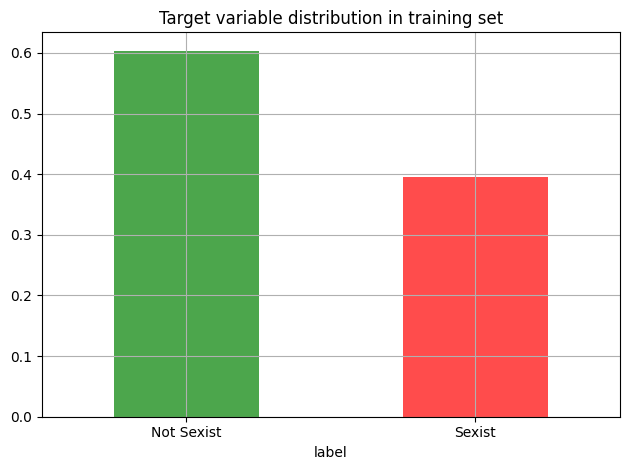

In [19]:
train.label.value_counts(normalize=True).plot(kind='bar', title='Target variable distribution in training set', color=['green', 'red'], alpha=0.7).set_xticklabels(['Not Sexist', 'Sexist'], rotation=0)
plt.grid()
plt.tight_layout()
plt.show()

# Task 2: Data Cleaning

>1. Remove emojis
>2. Remove hashtags (e.g. #metoo)
>3. Remove mentions (e.g. @user)
>4. Remove URLs
>5. Remove special characters and symbols
>6. Remove specific quote characters (e.g. curly quotes)
>7. Perform lemmatization

>**Bonus**: use other preprocessing strategies exploring techniques tailored specifically for tweets or methods that are common in social media text processing.

We slightly changed the order of the preprocessing to align more with the order followed by the GloVe preprocessing script tailored for tweets from Standford ([source](https://nlp.stanford.edu/projects/glove/preprocess-twitter.rb)). This ensures that our preprocessing pipeline matches the one used to create the GloVe dataset, hopefully improving performances:  
1. Remove URLs  
2. Remove mentions  
3. Remove hashtags  
4. Remove special characters  
5. Remove specific quote characters  
6. Perform lemmatization  

We chose not to remove emojis, since the GloVe dataset we are using contains some emojis, and we did not want to lose that information. The unknown emojis will be treated as normal out-of-vocabulary (OOV) tokens while the known emojis will be treated as normal words with their own embeddings.

To make comparisons later, we save a copy of the original dataset so we can print the preprocessed text next to the original one

In [20]:
original_train = train.copy()

Then we can apply all the preprocessing steps to the text as described above (in that order).

In [21]:
train['tweet'] = train['tweet'].apply(detector.preprocess_text)
val['tweet'] = val['tweet'].apply(detector.preprocess_text)
test['tweet'] = test['tweet'].apply(detector.preprocess_text)

### Perform lemmatization

The lemmatization is performed using the `nltk` library. The `lemmatize` method is used to perform the lemmatization of the text. The lemmatization is performed on the cleaned text and takes a bit since it has to process all the words in the text.

In [22]:
train['tweet'] = train['tweet'].apply(detector.lemmatize_text)
val['tweet'] = val['tweet'].apply(detector.lemmatize_text)
test['tweet'] = test['tweet'].apply(detector.lemmatize_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...


### Cast text to lowercase

The text is cast to lowercase to ensure that the model does not learn to distinguish between words based on the case of the letters (uncased).

In [23]:
train['tweet'] = train['tweet'].str.lower()
val['tweet'] = val['tweet'].str.lower()
test['tweet'] = test['tweet'].str.lower()

### Original and cleaned text

We can also inspect the difference between the original and cleaned text to see the effect of the preprocessing steps. As we can see the preprocessing steps have removed all the unwanted elements from the text and now the text is clean and ready to be used by the model.

In [24]:
detector.text_diff(preprocessed_text=train, original_text=original_train, random=True)

Original tweet:
@dawn_wife @ClarusPlusPlus Yeah, my middle names were patrilineal, and I changed to them to be both matrilineal
Processed tweet:
<user> <user> yeah my middle name were patrilineal and i changed to them to be both matrilineal


# Task 3: Text Encoding

>* Embed words using GloVe embeddings.

### Embed words using GloVe embeddings

The pretrained GloVe embeddings are used to embed the words in the text. First, we download the GloVe embeddings using the `gensim` library. We choose an embedding dimension of $100$. The specific model we use is `glove-twitter-100`, which is trained on Twitter data. Our intuition is that this model will perform better on tweets than other models trained on different data due to the fact that the language used in tweets differs from that in other types of text. By leveraging the specific language used in tweets, we aim to improve the model's performance and also reduce the number of out-of-vocabulary words (a common issue when using pretrained embeddings).

---

The vocabulary of the `glove-twitter-100` model is very large and contains many words. However, we are only using a subset of the words in the vocabulary, as we are focusing on the words used in the tweets. Additionally, since we are not interested in backpropagating the gradients to the embeddings, the magnitude of the embedding will not cause computational issues.

In [25]:
emb_model = detector.load_glove(model_name='glove-twitter', embedding_dim=EMBEDDING_DIM)
print(f"Vocabulary size: {len(emb_model.key_to_index)}")

Created folder models.
[==================================================] 100.0% 199.5/199.5MB downloaded
Model downloaded! Saving to models/glove-twitter-50
Model saved to models/glove-twitter-50
Vocabulary size: 1193514


We can now extract the two ordered dictionaries (`train_idx_to_word`, `train_word_to_idx`) as well as the set of words appearing in the training set.

In [26]:
train_idx_to_word, train_word_to_idx, train_word_listing = detector.get_vocab(train)

We can inspect how many words in the training set are not in the GloVe vocabulary.

This can be conveniente to assess the coverage of the GloVe embeddings on the training set. From our analysis we can see that the coverage using the GloVe embeddings model `glove-twitter-100` is better with respect to the model `glove-wiki-gigaword-100` which is trained on Wikipedia data. The actual difference is not so big (around 1%) but it can be important to have a good coverage of the embeddings on the training set. Moreover, such statistics do not take into account any possible difference in the quality of the embeddings which can be important to have a good performance of the model. The 1% difference might not be so important but the position of the words in the embeddings can be important to have a good performance of the model.

In [27]:
detector.get_oov_stats(emb_model, train_word_listing)

Total OOV terms: 768 (7.80%)


We can also inspect what are these OOV words to have an idea of the words that are not in the GloVe vocabulary.

In [28]:
list(detector.get_oov(emb_model, train_word_listing))[:10]

['johnleemushr',
 'colonizer',
 'sadrist',
 'dforce',
 'ultranationalism',
 'expereince',
 'afterpay',
 'deffend',
 'repeat>',
 'pavard']

As we can see the words that are not in the GloVe vocabulary are mostly slang words that are not so common in the English language. Also, this list contains words written wrongly (typos). The model will not be able to learn the embeddings for these words and will have to rely on the embeddings of similar words which can affect the performance of the model.

---

Now, to deal with these OOV tokens, we initially considered assigning a random vector to them. However, this might not be the best approach, as the model would learn to distinguish between the OOV tokens and the other tokens based on the embeddings. This is undesirable because the OOV tokens are not inherently different from the other tokens in the vocabulary.

A more effective approach would be to extract the co-occurrence matrix from the training set and use it to generate embeddings for the OOV tokens. By defining a window size, we can extract the co-occurrence matrix and then use it to generate the embeddings for the OOV tokens. Whenever an OOV token is encountered, we can define its embedding vector as the average of the embeddings of the most frequent words that co-occur with the OOV token. This way, the embeddings for the OOV tokens will be similar to those of the words that frequently co-occur with them. The similarity is derived from the co-occurrence matrix and the average of the embedding vectors.

This is the approach we will use to generate the embeddings for the OOV tokens. We will set the window size to 10 to extract the co-occurrence matrix and generate the embeddings for the OOV tokens.


In [29]:
co_occurrence_matrix = detector.co_occurrence_count(train, train_idx_to_word, train_word_to_idx, window_size=10)
co_occurrence_df = detector.co_occurrence_dataframe(co_occurrence_matrix, train_idx_to_word)
co_occurrence_df.head()

100%|██████████| 2870/2870 [00:07<00:00, 393.26it/s]


,writing,a,uni,essay,in,my,local,pub,with,coffee,...,armor,dragoon,estinen,nike,coochie,mutuals,owns,grabs,lh,mandy
writing,2.0,14.0,1.0,2.0,5.0,3.0,1.0,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a,14.0,1278.0,2.0,2.0,421.0,139.0,3.0,2.0,223.0,5.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,2.0
uni,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
essay,2.0,2.0,1.0,0.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
in,5.0,421.0,1.0,2.0,166.0,92.0,3.0,1.0,92.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


After computing the co-occurrence matrix we decided to combine the training set vocabulary with the GloVe vocabulary and generate the embedding vectors for the words in the training set that do not appear in the GloVe vocabulary. This is done to have a better coverage of the embeddings on the training set and to have a better performance of the model. The embeddings for the OOV tokens are generated using the co-occurrence matrix and the average of the embeddings of the most frequent words that co-occur with the OOV tokens.

In [30]:
emb_model_augmented = detector.get_augmented_vocab(emb_model, train_words=train_word_listing, co_occurrence_df=co_occurrence_df, save=True)

Saving vocab to data/vocab.json
Vocab saved!


Now we can just get all the vectors from the augmented GloVe and use them as embedding matrix for the model.

In [31]:
embedding_matrix = emb_model_augmented.vectors
print(f"Embedding matrix of {embedding_matrix.shape[0]} words, each of {embedding_matrix.shape[1]} dimensions")

Embedding matrix of 1194284 words, each of 50 dimensions


Before moving on the model definition we will first compute the class weights to deal with the class imbalance in the dataset. The class weights are computed using the `compute_class_weight` method from the `sklearn` library. The class weights are used to weight the loss function in order to give more importance to the minority class. This is important to have a better performance of the model and to deal with the class imbalance in the dataset. In this way the model will be aware of the class imbalance thus leading to a better f1 score.

In [32]:
class_weights_tensor = detector.get_class_weights(train, 'label')

# Task 4: Model definition

> * Baseline: Implement a Bidirectional LSTM with a Dense layer on top.
> * Model 1: add an additional LSTM layer to the baseline model.

### Baseline: Implement a Bidirectional LSTM with a Dense layer on top
As before, we chose to create a class that contains the structure of the network itself and a wrapper class to instantiate networks given different input parameters. This allows us to write cleaner code, in particular during the analysis

In [33]:
class BaselineModel(torch.nn.Module):
    def __init__(self, embedding_model, detector, hidden_dim, output_dim: int = 1, lstm_layers: int = 1, dropout: float = 0.3):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.lstm_layers = lstm_layers
        self.hidden_dim = hidden_dim

        self.word_embeddings = torch.nn.Embedding.from_pretrained(
            embeddings=torch.from_numpy(embedding_model.vectors),
            freeze=True,
            padding_idx=embedding_model.get_index(detector.PAD_TOKEN)
        )
        self.lstm = torch.nn.LSTM(input_size=embedding_model.vector_size, hidden_size=hidden_dim, bidirectional=True, num_layers=lstm_layers, batch_first=True)
        self.fc = torch.nn.Linear(in_features=2 * hidden_dim, out_features=output_dim)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, inputs):
        out = self.word_embeddings(inputs)
        out, _ = self.lstm(out)
        out = self.dropout(out)
        out = torch.mean(out, dim=1)  # Average pooling over the seq len
        out = self.fc(out)
        return out

# Task 5: Training and Evaluation

> * Train **all** models on the train set.
> * Evaluate **all** models on the validation set.
> * Compute metrics on the validation set.
> * Pick **at least** three seeds for robust estimation.
> * Pick the **best** performing model according to the observed validation set performance.
> * Evaluate your models using macro F1-score.

Here there's the definition of the wrapper class, that will be used to instantiate all the networks required

In [ ]:
class LSTM_network():
    def __init__(self, name: str, seed: int, detector: SexismDetector, embedding_model: gensim.models.keyedvectors.KeyedVectors, hidden_dim: int = 128, output_dim: int = 2, lstm_layers: int = 1, dropout: float = 0.5):
        self.name = name

        self.seed = seed
        self.__set_seed(seed)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.network = BaselineModel(embedding_model, detector, hidden_dim, output_dim, lstm_layers, dropout)
        self.network.to(device)
        self.detector = detector
        self.embedding_model = embedding_model
        self.history = None
        self.trained = False
        self.predictions = None
        self.labels = None
        # Clear the cache and perform garbage collection on initialization
        self.clear_cache()

    def __set_seed(self, seed):
        """
        Set the random seed for reproducibility.

        This method sets the seed for CUDA operations and NumPy to ensure that
        the results are reproducible. It also sets the CUBLAS workspace configuration
        to ensure deterministic results.

        Args:
            seed (int): The seed value to set for random number generation.
        """
        os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
        torch.cuda.manual_seed(seed)
        np.random.seed(seed)

    def clear_cache(self):
        """
        Clears the cache for CUDA and performs garbage collection.

        This method uses PyTorch's `torch.cuda.empty_cache()` to release all unoccupied cached memory
        currently held by the CUDA memory allocator, making that memory available for other GPU applications.
        It also calls Python's garbage collector to free up any unreferenced memory in the system.

        Note:
            This method should be used with caution as it can affect the performance of your application
            by causing memory fragmentation.
        """
        with torch.no_grad():
            torch.cuda.empty_cache()

        gc.collect()

    def train(self, training_set: pd.DataFrame, validation_set: pd.DataFrame, epochs: int, batch_size: int, lr: float, weight_decay: float, verbose=True):
        # Get the train and validation dataloader
        train_dloader = self.detector.get_dataloader(data=training_set,
                                                    embedding_model=self.embedding_model,
                                                    type="train",
                                                    batch_size=batch_size,
                                                    shuffle=True)

        val_dloader = self.detector.get_dataloader(data=validation_set,
                                                embedding_model=self.embedding_model,
                                                type="val",
                                                batch_size=validation_set.shape[0],
                                                shuffle=False)

        # Initialize the history
        history = pd.DataFrame(columns=['model', 'epoch', 'train_loss', 'val_loss', 'train_acc', 'val_acc', 'learning_rate'])

        class_weights_tensor = self.detector.class_weights
        criterion = torch.nn.CrossEntropyLoss(
            weight=class_weights_tensor.to(device),
            ignore_index=self.embedding_model.get_index(self.detector.PAD_TOKEN)
        )

        optimizer = torch.optim.AdamW(self.network.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

        # Initialize parameters for Early stopping
        best_val_loss = np.inf
        best_model = None
        best_model_epoch = 0
        best_f1_score = 0

        # Train the model
        for epoch in range(epochs):
            train_correct = 0
            train_total = 0
            grad_loss_vec = []

            # Training phase
            self.network.train()
            for batch in train_dloader:
                sentences, labels = batch
                sentences, labels = sentences.to(device), labels.to(device)

                optimizer.zero_grad()
                output = self.network(sentences)
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()

                predicted = torch.argmax(output, dim=1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

                # Save the gradients for the current batch
                grad_loss_vec.append(loss.item())

            # Validation phase
            self.network.eval()
            final_val_loss = 0
            val_correct = 0
            val_total = 0
            predicted_arr = []
            labels_arr = []

            with torch.no_grad():
                for batch in val_dloader:
                    sentence, labels = batch
                    sentence, labels = sentence.to(device), labels.to(device)

                    output = self.network(sentence)
                    val_loss = criterion(output, labels)
                    final_val_loss += val_loss.item()

                    predicted = torch.argmax(output, dim=1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

                    predicted_arr.append(predicted)
                    labels_arr.append(labels)

            predicted_arr = torch.cat(predicted_arr, dim=0).cpu().numpy()
            labels_arr = torch.cat(labels_arr, dim=0).cpu().numpy()

            f1 = f1_score(labels_arr, predicted_arr, average='macro')

            scheduler.step(final_val_loss)

            if final_val_loss < best_val_loss:
                best_val_loss = final_val_loss
                best_model = copy.deepcopy(self.network.state_dict())
                best_model_epoch = epoch
                best_f1_score = f1

            # Compute the mean loss for the epoch across all batches
            loss_value = np.mean(grad_loss_vec)

            if verbose:
                print(f"Epoch {epoch + 1}/{epochs}\tLoss: {loss_value:.4f}\tAcc: {train_correct / train_total:.4f}\t"
                    f"Val Loss: {final_val_loss:.4f}\tVal Acc: {val_correct / val_total:.4f}\tmacro_f1: {f1:.4f}\t"
                    f"lr: {scheduler.get_last_lr()[0]:.7f}")

            history.loc[len(history)] = [self.name, epoch + 1, loss_value, final_val_loss, train_correct / train_total, val_correct / val_total, scheduler.get_last_lr()[0]]

        # Restore the best model
        self.network.load_state_dict(best_model)
        print(f"Best model found at epoch {best_model_epoch + 1} with validation loss: {best_val_loss:.4f} and f1 score: {best_f1_score:.4f}")

        # Compute metrics on validation set with the best model
        self.network.eval()
        predicted_arr = []
        labels_arr = []

        with torch.no_grad():
            for batch in val_dloader:
                sentence, labels = batch
                sentence, labels = sentence.to(device), labels.to(device)

                output = self.network(sentence)
                predicted = torch.argmax(output, dim=1)
                predicted_arr.append(predicted)
                labels_arr.append(labels)

        predicted_arr = torch.cat(predicted_arr, dim=0).cpu().numpy()
        labels_arr = torch.cat(labels_arr, dim=0).cpu().numpy()

        final_accuracy = accuracy_score(labels_arr, predicted_arr)
        final_precision = precision_score(labels_arr, predicted_arr, average='macro')
        final_recall = recall_score(labels_arr, predicted_arr, average='macro')
        final_f1 = f1_score(labels_arr, predicted_arr, average='macro')

        print(f"Final metrics after loading the best model:\n"
            f"Accuracy: {final_accuracy:.4f}, Precision: {final_precision:.4f}, Recall: {final_recall:.4f}, F1: {final_f1:.4f}")

        torch.save(self.network.state_dict(), detector.MODEL_FOLDER / f'{self.name}.pth')
        self.history = history
        self.trained = True
        self.predictions = predicted_arr
        self.labels = labels_arr

        return history, final_accuracy, final_precision, final_recall, final_f1

    def plot_history(self):
        if self.trained:
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
            baseline_model_name = self.history['model'] == self.name
            self.history[baseline_model_name].plot(x='epoch', y=['train_loss', 'val_loss'], title='Loss', ax=axes[0])
            self.history[baseline_model_name].plot(x='epoch', y=['train_acc', 'val_acc'], title='Accuracy', ax=axes[1])
            self.history[baseline_model_name].plot(x='epoch', y='learning_rate', title='Learning Rate', ax=axes[2], logy=True)

            plt.tight_layout()
            plt.show()
        else:
            raise Exception("You need to train the model first!")

# LSTMs

The idea here is to run three times the baseline model with different seeds and then average the performance over the seeds with the standard deviation. This is done to have a robust estimation of the performance of the model and to have a better idea of the performance of the model.

In [ ]:
# Accumulate the results of each seed
lstm_results_df = pd.DataFrame(columns=['name', 'accuracy', 'precision', 'recall', 'f1', 'layers'])

Training baseline model with seed 1337
Best model found at epoch 42 with validation loss: 0.5731 and f1 score: 0.6980
Final metrics after loading the best model:
Accuracy: 0.7089, Precision: 0.7039, Recall: 0.6959, F1: 0.6980


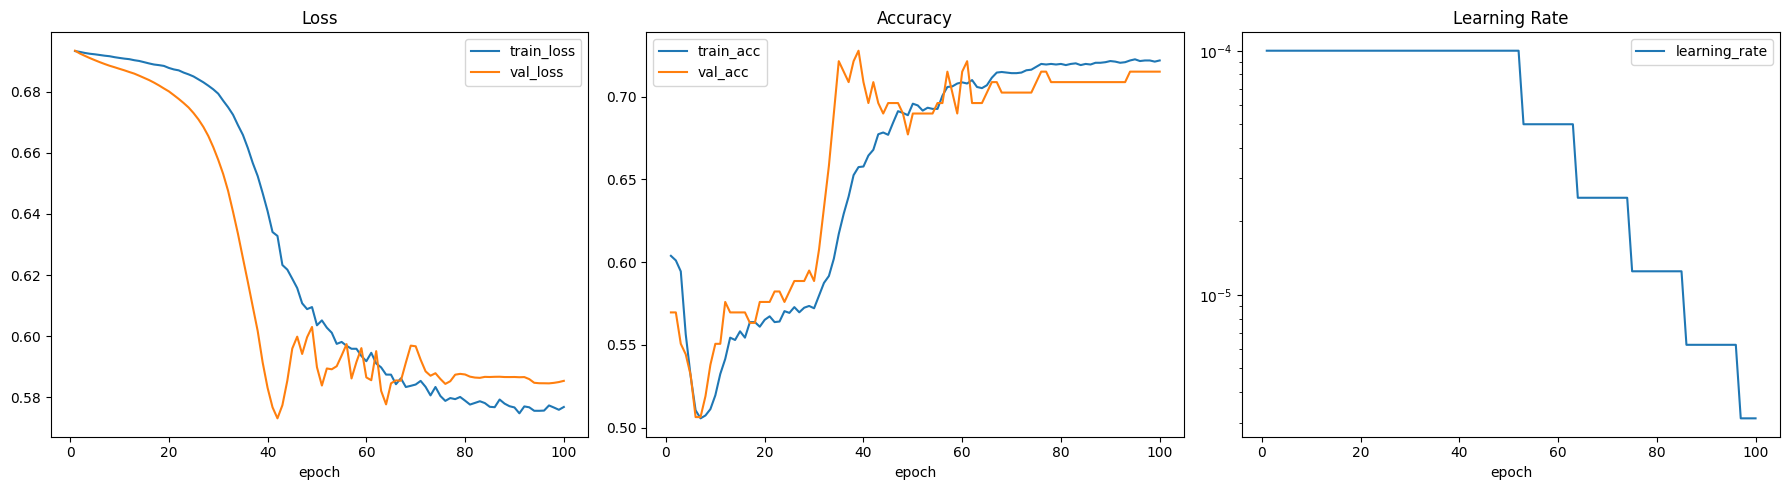

Training model with two LSTM layers with seed 1337
Best model found at epoch 47 with validation loss: 0.5174 and f1 score: 0.7745
Final metrics after loading the best model:
Accuracy: 0.7785, Precision: 0.7741, Recall: 0.7750, F1: 0.7745


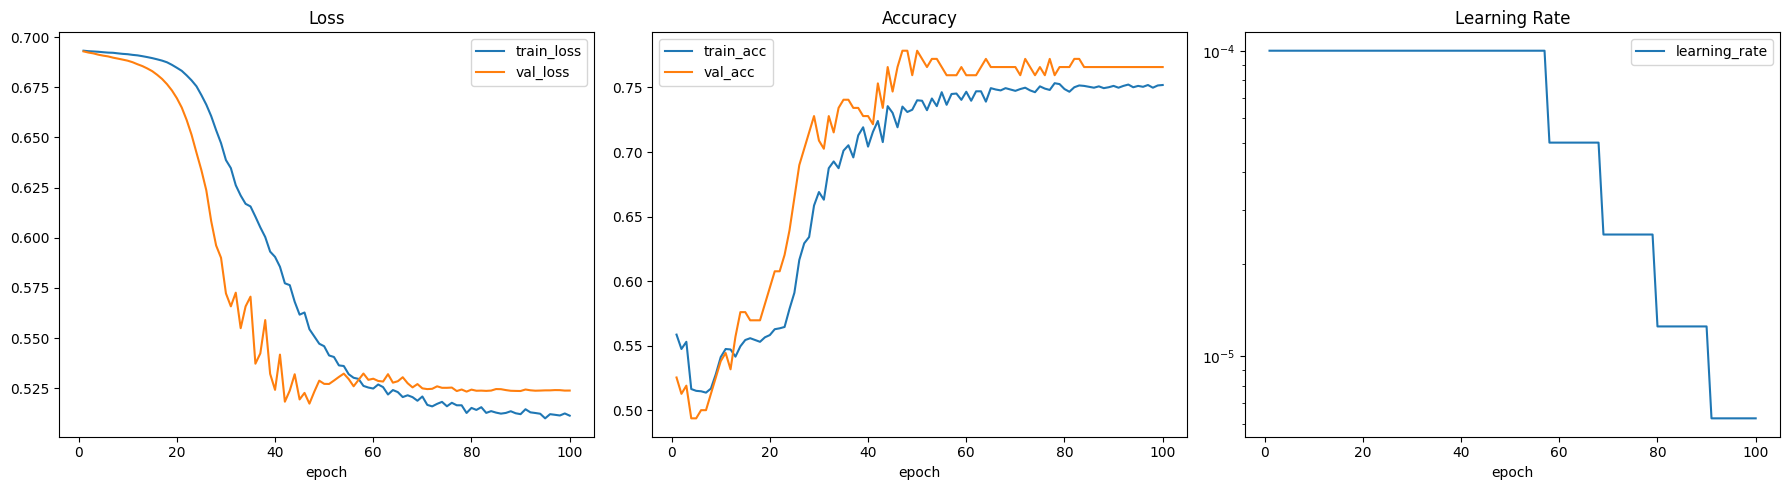

Training baseline model with seed 42
Best model found at epoch 87 with validation loss: 0.5442 and f1 score: 0.7279
Final metrics after loading the best model:
Accuracy: 0.7342, Precision: 0.7289, Recall: 0.7271, F1: 0.7279


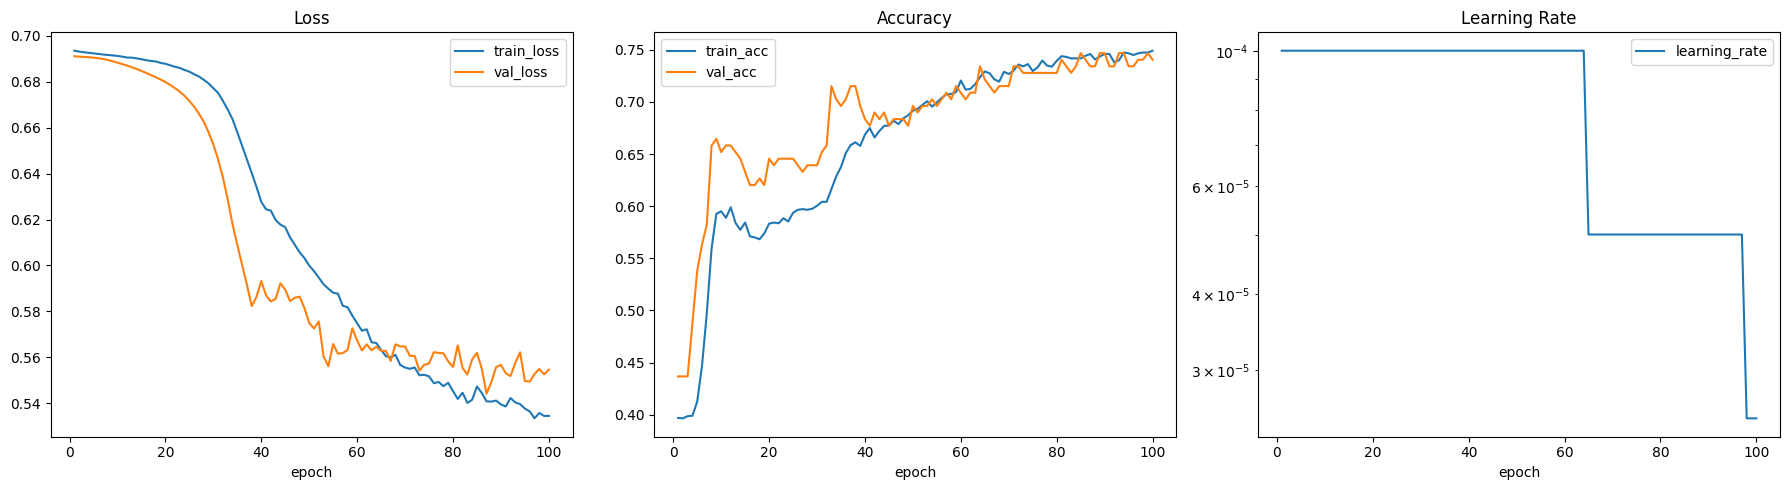

Training model with two LSTM layers with seed 42
Best model found at epoch 56 with validation loss: 0.5113 and f1 score: 0.7588
Final metrics after loading the best model:
Accuracy: 0.7658, Precision: 0.7625, Recall: 0.7567, F1: 0.7588


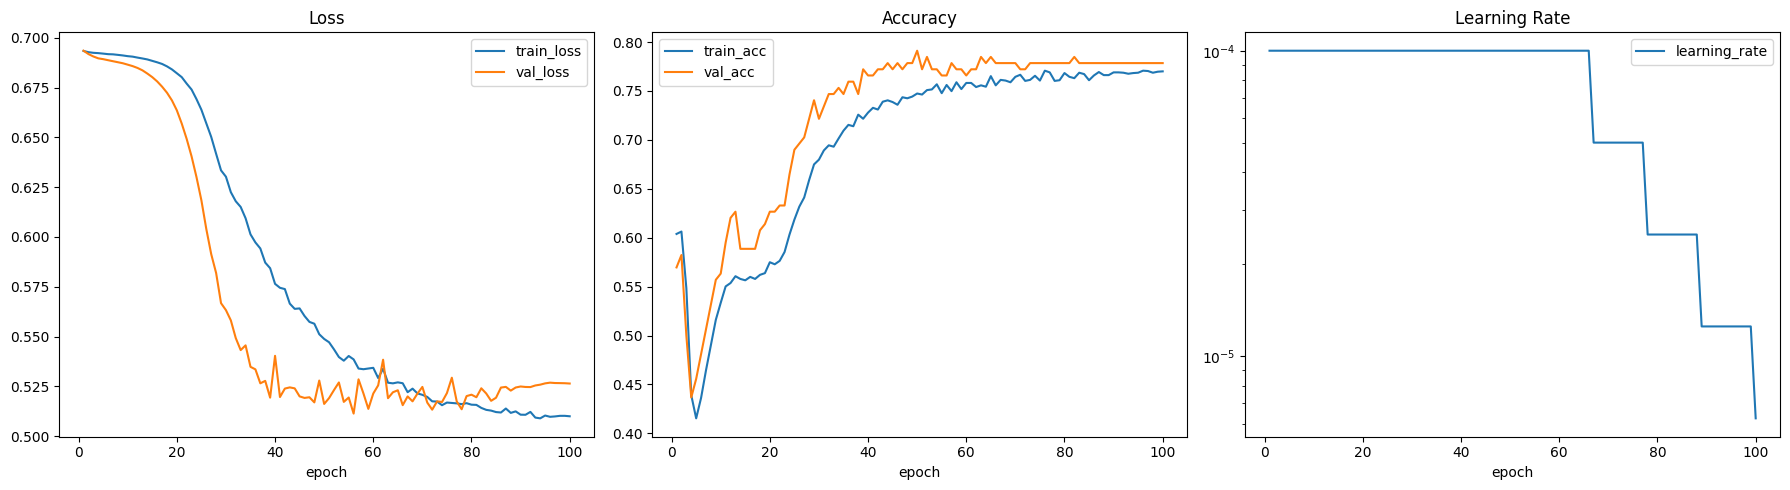

Training baseline model with seed 69
Best model found at epoch 70 with validation loss: 0.5335 and f1 score: 0.7315
Final metrics after loading the best model:
Accuracy: 0.7405, Precision: 0.7369, Recall: 0.7291, F1: 0.7315


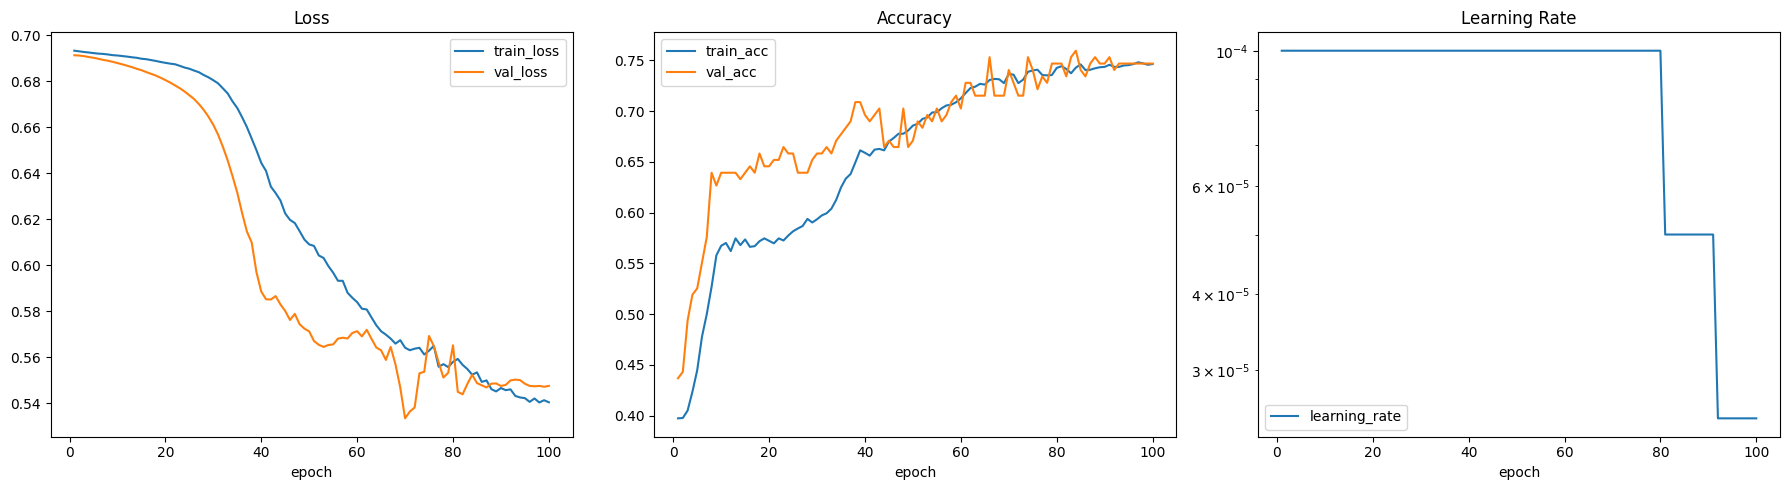

Training model with two LSTM layers with seed 69
Best model found at epoch 52 with validation loss: 0.5236 and f1 score: 0.7537
Final metrics after loading the best model:
Accuracy: 0.7658, Precision: 0.7695, Recall: 0.7495, F1: 0.7537


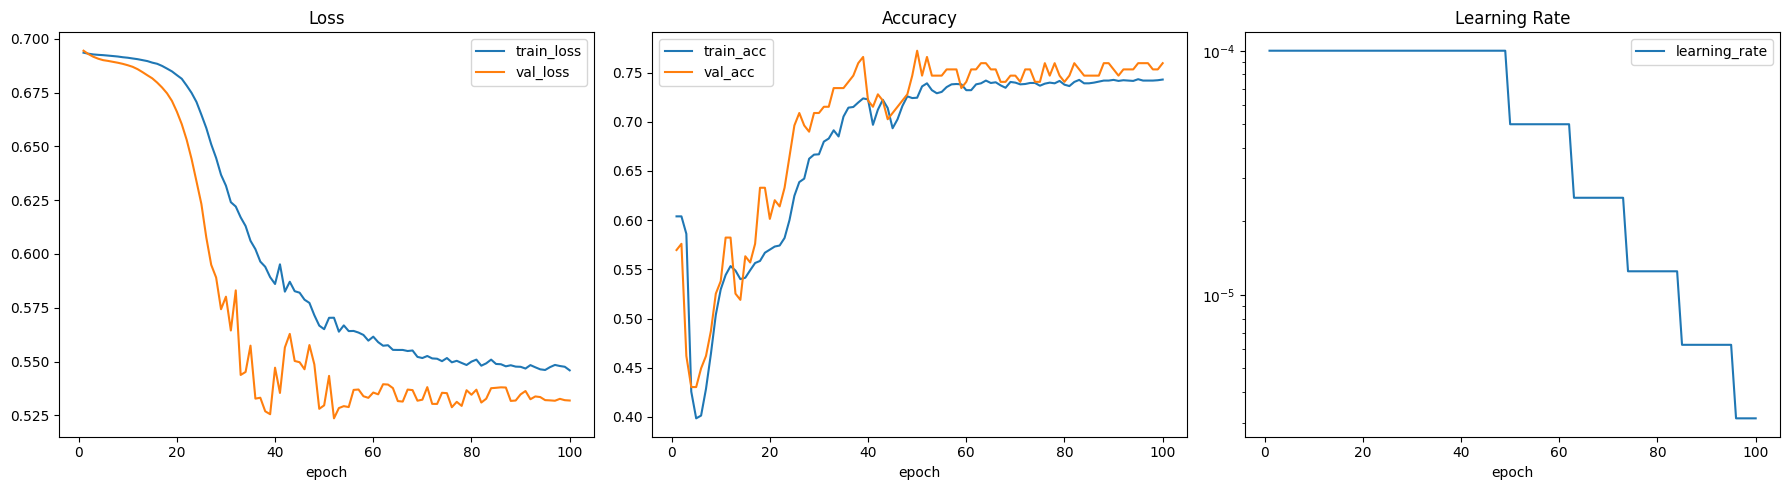

In [ ]:
for seed in seeds:
    # Baseline model
    print(f"Training baseline model with seed {seed}")
    lstm = LSTM_network(f"baseline_{seed}",
                        seed,
                        detector,
                        emb_model_augmented,
                        hidden_dim=HIDDEN_DIM,
                        output_dim=2,
                        lstm_layers=1,
                        dropout=0.4)

    history, accuracy, precision, recall, f1 = lstm.train(train, val, EPOCHS, BATCH_SIZE, LEARNING_RATE, weight_decay=1e-5, verbose=False)

    # Save the predictions and labels inside the dict
    predictions_dict[lstm.name] = {'predictions': lstm.predictions, 'labels': lstm.labels}

    lstm.plot_history()

    lstm_results_df.loc[len(lstm_results_df)] = [lstm.name, accuracy, precision, recall, f1, lstm.network.lstm_layers]

    # Model with two LSTM layers
    print(f"Training model with two LSTM layers with seed {seed}")
    lstm_2_layers = LSTM_network(f"2_layers_{seed}",
                                 seed,
                                 detector,
                                 emb_model_augmented,
                                 hidden_dim=HIDDEN_DIM,
                                 output_dim=2,
                                 lstm_layers=2,
                                 dropout=0.4)

    history, accuracy, precision, recall, f1 = lstm_2_layers.train(train, val, EPOCHS, BATCH_SIZE, LEARNING_RATE, weight_decay=1e-5, verbose=False)

    # Save the predictions and labels inside the dict
    predictions_dict[lstm_2_layers.name] = {'predictions': lstm_2_layers.predictions, 'labels': lstm_2_layers.labels}

    lstm_2_layers.plot_history()

    lstm_results_df.loc[len(lstm_results_df)] = [lstm_2_layers.name, accuracy, precision, recall, f1, lstm_2_layers.network.lstm_layers]

Now we can get the mean and the standard deviation of the performance of the model over the seeds. This is done to have a better idea of the performance of the model and to have a robust estimation of the performance of the model.

In [ ]:
lstm_results_df

,name,accuracy,precision,recall,f1,layers
0,baseline_1337,0.708861,0.703912,0.695915,0.697972,1
1,2_layers_1337,0.778481,0.774060,0.775000,0.774497,2
2,baseline_42,0.734177,0.728920,0.727124,0.727899,1
3,2_layers_42,0.765823,0.762490,0.756699,0.758779,2
4,baseline_69,0.740506,0.736944,0.729085,0.731460,1
5,2_layers_69,0.765823,0.769550,0.749510,0.753739,2


In [ ]:
lstm_results_df_index = lstm_results_df.set_index('name')
print('Results for the baseline model:')
lstm_results_df_index[lstm_results_df_index['layers'] == 1].agg(['mean', 'std']).drop(columns='layers')

Results for the baseline model:


,accuracy,precision,recall,f1
mean,0.727848,0.723259,0.717375,0.719110
std,0.016745,0.017229,0.018610,0.018393


In [ ]:
print('Results for the model with two LSTM layers:')
lstm_results_df_index[lstm_results_df_index['layers'] == 2].agg(['mean', 'std']).drop(columns='layers')

Results for the model with two LSTM layers:


,accuracy,precision,recall,f1
mean,0.770042,0.768700,0.760403,0.762338
std,0.007308,0.005832,0.013143,0.010828


Now pick the best performing model according to the observed validation set performance

In [ ]:
# Model with  best f1 score (macro)

best_model_name = lstm_results_df_index['f1'].idxmax()
print(f"Best model: {best_model_name} with f1 score: {lstm_results_df_index.loc[best_model_name, 'f1']:.4f}")

Best model: 2_layers_1337 with f1 score: 0.7745


# Task 6: Transformers

https://huggingface.co/cardiffnlp/twitter-roberta-base-hate

In [80]:
def preprocess_text(texts):
    return tokenizer(texts['tweet'])

def compute_metrics(output_info):
        """
        Compute various evaluation metrics for model predictions.

        Args:
            output_info (tuple): A tuple containing the model predictions and the true labels.
                - predictions (np.ndarray): The predicted labels from the model.
                - labels (np.ndarray): The true labels.

        Returns:
            dict: A dictionary containing the computed metrics:
                - 'f1': The F1 score (macro average).
                - 'accuracy': The accuracy score.
                - 'precision': The precision score (macro average).
                - 'recall': The recall score (macro average).
        """
        #acc_metric = evaluate.load('accuracy')
        #f1_metric = evaluate.load('f1')
        #precision_metric = evaluate.load("precision")
        #recall_metric = evaluate.load("recall")

        predictions, labels = output_info
        #LINE REMOVED
        predictions = np.array(predictions)
        labels = np.array(labels)
        predictions = np.argmax(predictions, axis=-1)



        #f1 = f1_metric.compute(predictions=predictions, references=labels, average='macro')
        #acc = acc_metric.compute(predictions=predictions, references=labels)
        #precision = precision_metric.compute(predictions=predictions, references=labels, average='macro')
        #recall = recall_metric.compute(predictions=predictions, references=labels, average='macro')

        f1 = f1_score(labels, predictions, average="macro")
        acc = accuracy_score(labels, predictions)
        prec = precision_score(labels, predictions, average="macro")
        rec = recall_score(labels,predictions, average="macro")

        return {"f1-score" : f1, "Accuracy" : acc, "Precision":prec, "Recall":rec}

In [81]:
# Since we know that there is a slightly imbalance in the dataset labels, instead of using the default Trainer class of HuggingFace, we can write a custom class inheriting from the Trainer class and override the `compute_loss` method to compute the loss with the class weights computed from the dataset labels. In this way the loss function will take into account the imbalance in the dataset labels and will give more importance to the minority class. The impact of this change is that the F1 and accuracy scores will be more similar to each other since the model will be trained to give more importance to the minority class w.r.t. the majority class.

# Taken from https://github.com/huggingface/transformers/blob/main/src/transformers/trainer.py#L3700 (with some minor changes removing useless parts)
class CustomTrainer(Trainer):
    def __init__(self, class_weights, device, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # You pass the class weights when instantiating the Trainer
        self.class_weights = class_weights
        self.device = device

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels")
        else:
            labels = None
        outputs = model(**inputs)
        # Save past state if it exists
        # TODO: this needs to be fixed and made cleaner later.
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            loss = self.label_smoother(outputs, labels)
        else:
            # We don't use .loss here since the model may return tuples instead of ModelOutput.

            # Do not
            # loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]
            logits = outputs.get('logits')
            criterion = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(self.device))
            loss = criterion(logits, inputs['labels'])

        return (loss, outputs) if return_outputs else loss

In [82]:
# Get the train, val and test datasets
train_data = Dataset.from_pandas(train)
val_data = Dataset.from_pandas(val)
test_data = Dataset.from_pandas(test)

# Define the model card
model_card = 'cardiffnlp/twitter-roberta-base-hate'

# Get the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_card, use_Fast=True)

# Select the right column
train_data = train_data.map(preprocess_text, batched=True)
val_data = val_data.map(preprocess_text, batched=True)
test_data = test_data.map(preprocess_text, batched=True)

# Get the data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/2870 [00:00<?, ? examples/s]

Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Map:   0%|          | 0/286 [00:00<?, ? examples/s]

In [83]:
def twitter_roberta_base(model_card: str, seed: int, class_weights: torch.Tensor, train_data: Dataset, val_data: Dataset, test_data: Dataset, data_collator):

  # Load the Model
  model = AutoModelForSequenceClassification.from_pretrained(model_card, num_labels=2, id2label={0: 'NEG', 1: 'POS'}, label2id={'NEG': 0, 'POS': 1})

  # Get the training arguments
  training_args = TrainingArguments(
      output_dir="models",                 # where to save model
      learning_rate=ROBERTA_LEARNING_RATE,
      per_device_train_batch_size=ROBERTA_BATCH_SIZE,         # accelerate defines distributed training
      num_train_epochs=ROBERTA_EPOCHS,
      weight_decay=1e-5,
      eval_strategy="epoch",           # when to report evaluation metrics/losses
      save_strategy="epoch",                 # when to save checkpoint
      load_best_model_at_end=True,
      report_to='none',                    # disabling wandb (default)
      seed=seed,
      data_seed=seed
  )

  # Get the trainer
  trainer = CustomTrainer(
              model=model,
              args=training_args,
              train_dataset=train_data,
              eval_dataset=test_data,
              data_collator=data_collator,
              compute_metrics=compute_metrics,
              class_weights=class_weights_tensor,
              device=device,
          )

  # Train the model
  trainer.train()

  # Get the predictions
  predictions_info = trainer.predict(test_data)
  predictions, labels = predictions_info.predictions, predictions_info.label_ids

  # Update the predictions dict with the new predictions
  model_name = model_card.split('/')[-1]
  predictions_dict[f'{model_name}_{seed}'] = {'predictions': np.argmax(predictions, axis=-1), 'labels': labels}

### Twitter roBERTa base hate model with seed 1337

In [84]:
twitter_roberta_base(
    model_card = model_card,
    seed = 1337,
    class_weights = class_weights_tensor,
    train_data = train_data,
    val_data = val_data,
    test_data = test_data,
    data_collator = data_collator
)

Epoch,Training Loss,Validation Loss,F1-score,Accuracy,Precision,Recall
1,No log,0.378198,0.821309,0.821678,0.823594,0.827976
2,No log,0.375434,0.826635,0.828671,0.825976,0.827480
3,0.368900,0.374241,0.826891,0.828671,0.825979,0.828323
4,0.368900,0.410161,0.826066,0.828671,0.826360,0.825794
5,0.368900,0.405391,0.827131,0.828671,0.826109,0.829167


KeyboardInterrupt: 

### Twitter roBERTa base hate model with seed 42

In [ ]:
twitter_roberta_base(
    model_card = model_card,
    seed = 42,
    class_weights = class_weights_tensor,
    train_data = train_data,
    val_data = val_data,
    test_data = test_data,
    data_collator = data_collator
)

### Twitter roBERTa base hate model with seed 69

In [64]:
twitter_roberta_base(
    model_card = model_card,
    seed = 69,
    class_weights = class_weights_tensor,
    train_data = train_data,
    val_data = val_data,
    test_data = test_data,
    data_collator = data_collator
)

Map:   0%|          | 0/2870 [00:00<?, ? examples/s]

Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Map:   0%|          | 0/286 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,F1-score,Accuracy,Precision,Recall
1,No log,0.381561,0.816667,0.818182,0.815691,0.818948
2,No log,0.370483,0.823718,0.825175,0.822712,0.826042
3,0.359300,0.376432,0.842099,0.842657,0.842657,0.847569
4,0.359300,0.372835,0.848298,0.849650,0.847192,0.850446
5,0.359300,0.391709,0.851726,0.853147,0.850649,0.853571
6,0.239500,0.392403,0.848493,0.849650,0.847412,0.851290


# Task 7: Error Analysis

After evaluating the model, perform a brief error analysis:

 - Review the results and identify common errors.

 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)
 - Suggest possible solutions to address the identified errors.

In [74]:
class Metrics:
    def __init__(self, predictions_dict: dict):
        self.predictions_dict = predictions_dict
        self.models = list(predictions_dict.keys())
        self.ensembled_dict = {}

    def majority_voting(self):
        """
        Apply majority voting to the given predictions.

        Args:
            predictions (np.ndarray): The predictions to be aggregated.

        Returns:
            np.ndarray: The aggregated predictions based on majority voting.
        """
        baseline_models = [model for model in self.models if model.startswith('baseline')]
        two_lstms = [model for model in self.models if model.startswith('2_layers')]
        roberta_models = [model for model in self.models if model.startswith('twitter')]

        threshold = len(baseline_models) // 2 + 1

        # Stack vertically the predictions of the models
        try:
            baseline_predictions = np.vstack([self.predictions_dict[model]['predictions'] for model in baseline_models])
            colsum = np.sum(baseline_predictions, axis=0)
            majority_voting = (colsum >= threshold).astype(int)
            self.ensembled_dict['baseline'] = {'predictions': majority_voting, 'labels': self.predictions_dict[baseline_models[0]]['labels']}
        except ValueError: # Models not trained
            pass

        try:
            two_lstm_predictions = np.vstack([self.predictions_dict[model]['predictions'] for model in two_lstms])
            colsum = np.sum(two_lstm_predictions, axis=0)
            majority_voting = (colsum >= threshold).astype(int)
            self.ensembled_dict['2_layers'] = {'predictions': majority_voting, 'labels': self.predictions_dict[two_lstms[0]]['labels']}
        except ValueError: # Models not trained
            pass

        try:
            roberta_predictions = np.vstack([self.predictions_dict[model]['predictions'] for model in roberta_models])
            colsum = np.sum(roberta_predictions, axis=0)
            majority_voting = (colsum >= threshold).astype(int)
            self.ensembled_dict['twitter'] = {'predictions': majority_voting, 'labels': self.predictions_dict[roberta_models[0]]['labels']}
        except ValueError: # Models not trained
            pass


    def get_confusion_matrix(self, predictions: np.ndarray, labels: np.ndarray, title: str, ax=None):
        """
        Generates and displays a confusion matrix for the given predictions and labels.

        Args:
            predictions (numpy.ndarray): The predicted probabilities or logits for each class.
            labels (numpy.ndarray): The true labels for the data.

        Returns:
            None: This function displays the confusion matrix plot and does not return any value.
        """
        cm = confusion_matrix(y_true=labels, y_pred=predictions)
        display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-sexist', 'Sexist']).plot(cmap='viridis', ax=ax)
        _ = display.ax_.set_title(title)

    def get_precision_recall(self, predictions: np.ndarray, labels: np.ndarray, model_name: str, plot_title: str, ax=None):
        """
        Calculate and display the precision-recall curve for the given predictions and labels.

        Args:
            predictions (np.ndarray): The predicted probabilities or logits from the model.
            labels (np.ndarray): The true labels for the data.

        Returns:
            None: This function displays the precision-recall curve using matplotlib.
        """
        display = PrecisionRecallDisplay.from_predictions(y_true=labels, y_pred=predictions, name=model_name, plot_chance_level=True, ax=ax)
        _ = display.ax_.set_title(plot_title)

    def get_f1_score(self, predictions: np.ndarray, labels: np.ndarray):
        """
        Calculate the F1 score for the given predictions and labels.

        Args:
            predictions (np.ndarray): The predicted probabilities or logits from the model.
            labels (np.ndarray): The true labels for the data.

        Returns:
            float: The F1 score for the model predictions.
        """
        return f1_score(y_true=labels, y_pred=predictions, average='macro')

    def contains_OOV(self, text: str, tokenizer: AutoTokenizer):
        """
        Return the out-of-vocabulary (OOV) words in a given text.
        """
        vocab_words = list(tokenizer.vocab.keys())
        return set(word for word in text.split() if word not in vocab_words)

    def review_errors(self, preprocessed_data, predictions, labels, tokenizer: AutoTokenizer, verbose: bool = False):
        """
        Analyzes and reviews errors in model predictions.

        Args:
            original_data (pd.DataFrame): The original dataset containing the true labels.
            preprocessed_data (pd.DataFrame): The preprocessed dataset used for predictions.
            predictions (np.ndarray): The model's predictions.
            labels (np.ndarray): The true labels.
            verbose (bool, optional): If True, prints detailed information about each error. Defaults to False.

        Returns:
            list: A list of tweet IDs where the model made incorrect predictions.

        Prints:
            - The total number of errors found.
            - Detailed information about each error if verbose is True.
            - The number and percentage of errors due to Out-Of-Vocabulary (OOV) words.
        """
        errors = []
        for i, (pred, label) in enumerate(zip(predictions, labels)):
            if pred != label:
                errors.append(i)

        print(f"Found {len(errors)} errors out of {len(labels)} samples.")

        errors_due_to_OOV = 0
        for i in errors:
            tweet_text = preprocessed_data['tweet'][i]
            oov_found = self.contains_OOV(tweet_text, tokenizer)
            if len(oov_found) > 0:
                errors_due_to_OOV += 1
            if verbose:
                print(f"""
                Contains OOV: {oov_found if len(oov_found) > 0 else 'No'}
                Tweet: {tweet_text}
                Predicted: {predictions[i]}
                True Label: {labels[i]}
                """)
        print(f"Errors due to OOV: {errors_due_to_OOV}, {errors_due_to_OOV / len(errors) * 100:.2f}%")

F1 scores for the ensembled models: {'twitter': 0.824134199134199}, Accuracy: {'twitter': 0.8251748251748252}


NameError: name 'tokenizer' is not defined

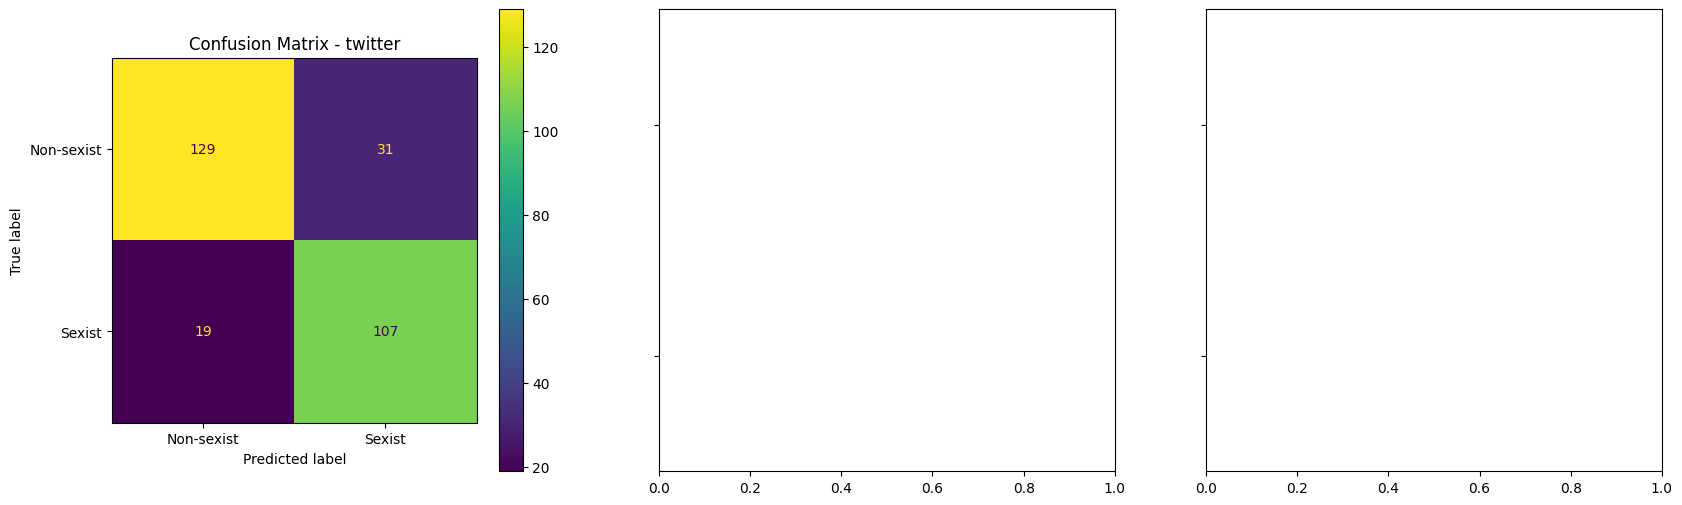

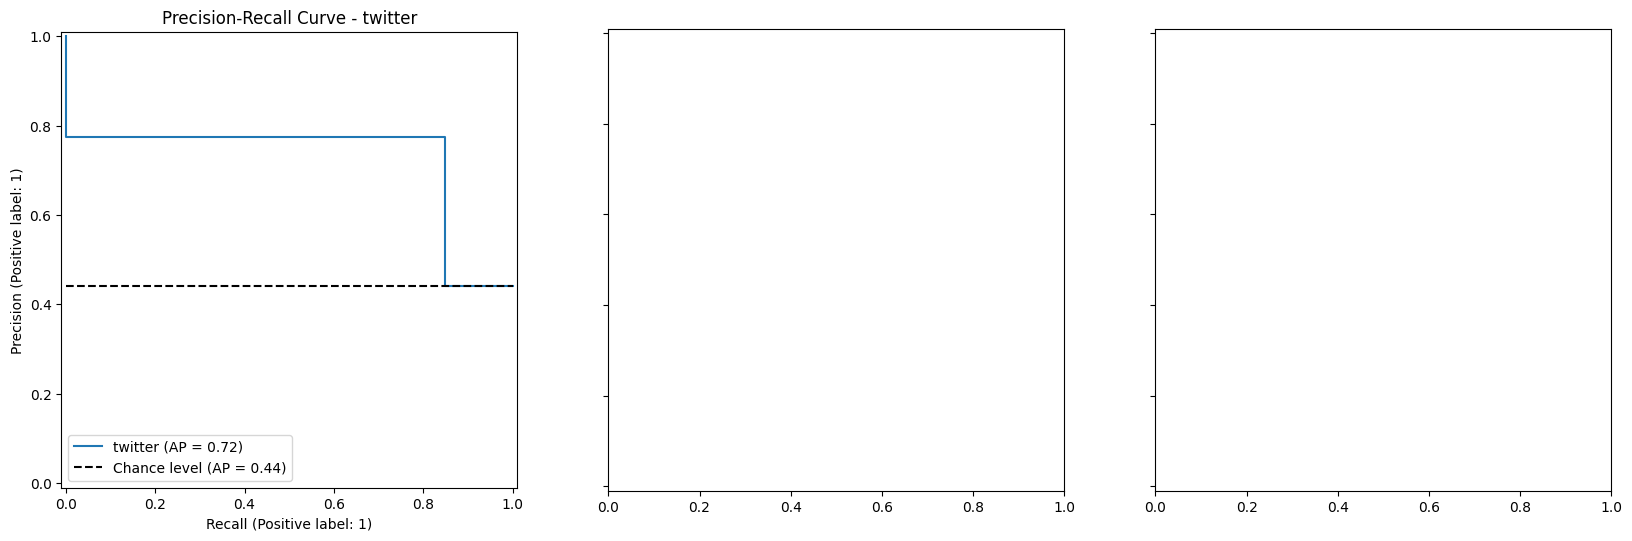

In [77]:
metrics = Metrics(predictions_dict=predictions_dict)

# Get the ensemble predictions
metrics.majority_voting()

fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Plot the confusion matrix for each of the models Cardiff Twitter RoBERTa Base
for i, model_name in enumerate(list(metrics.ensembled_dict.keys())):
    predictions = metrics.ensembled_dict[model_name]['predictions']
    labels = metrics.ensembled_dict[model_name]['labels']
    metrics.get_confusion_matrix(predictions, labels, title=f"Confusion Matrix - {model_name}", ax=ax[i])

fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Plot the precision-recall curve for each of the models Cardiff Twitter RoBERTa Base
for i, model_name in enumerate(list(metrics.ensembled_dict.keys())):
    predictions = metrics.ensembled_dict[model_name]['predictions']
    labels = metrics.ensembled_dict[model_name]['labels']
    metrics.get_precision_recall(predictions, labels, model_name, f"Precision-Recall Curve - {model_name}", ax=ax[i])

# Calculate the F1 score for each of the ensembled models
f1_scores_ensembled = {model_name: metrics.get_f1_score(metrics.ensembled_dict[model_name]['predictions'], metrics.ensembled_dict[model_name]['labels']) for model_name in metrics.ensembled_dict.keys()}
accuracy_ensembled = {model_name: accuracy_score(metrics.ensembled_dict[model_name]['labels'], metrics.ensembled_dict[model_name]['predictions']) for model_name in metrics.ensembled_dict.keys()}
print(f"F1 scores for the ensembled models: {f1_scores_ensembled}, Accuracy: {accuracy_ensembled}")

for model_name in metrics.ensembled_dict.keys():
    wrong_tweet_ids = metrics.review_errors(preprocessed_data=test_data, predictions=metrics.ensembled_dict[model_name]['predictions'], labels=metrics.ensembled_dict[model_name]['labels'], tokenizer=tokenizer, verbose=True)

Common errrors spotted so far:

* Most of the errors are due to the fact that the model is not able to distinguish between the sexist and non-sexist tweets.
    * The predicted score is the opposite of the true score. This is a common error in classification tasks and can be due to the fact that the model is not able to learn the features that distinguish between the two classes.
    * All the missclassified tweets contain, at least, one word which is not in the vocabulary of the roBERTa. This for sure has an impact in the performance of the model since the model is not able to learn the embeddings for these words and loses information about the tweets. Indeed these OOVs are special tokens of the GloVe embeddings and are not present in the roBERTa vocabulary. This is a common problem when using pretrained embeddings. Moreover, this version of roBERTa has just a few special tokens as visible from the [map on huggingface](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate/blob/main/special_tokens_map.json).
    * A model which includes the special tokens for user mentions, url, elongations, etc. might perform better on this task since it will be able to learn the embeddings for these tokens and have better performances.

# Task 8: Report

Wrap up your experiment in a short report (up to 2 pages).

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Appendix

## Custom Input

Here you can try the model to see how it works with custom input. It works pretty well detecting plain sexism, but it struggles with certain phrases containing subtle sexism.

These are still good results, considering the dimension of the dataset used, which is quite small


In [ ]:
def sexism_detector(phrase):
    phrase = detector.preprocess_text(phrase)
    phrase = detector.lemmatize_text(phrase)
    phrase = phrase.lower()

    tokens = roberta.tokenizer(
        phrase,
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt"
    )

    phrase_dataset = Dataset.from_dict({
    "input_ids": tokens["input_ids"],
    "attention_mask": tokens["attention_mask"],
    })

    pred = trainer.predict(phrase_dataset)

    return "Not sexist!" if np.argmax(pred.predictions, axis=-1) == 0 else "Sexist!"


In [ ]:
phrase = input("Insert your phrase: ")
print(sexism_detector(phrase))